# Arrival Time Prediction - Training
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import time
import pickle
import gp_gpy as gp
import plot 
import GPy

sns.set(style="darkgrid")
np.random.seed(1)
train = pd.read_pickle('train.pkl')
n_trajs = train.traj.unique()
n_trajs_to_use = 50
train = train[train.traj < n_trajs[n_trajs_to_use]]
route_n = 3 # all data used currently is from route 3
n_segs = train.seg.unique()
train.head()

def synch_traj(synch_gp, data):
    X = data[['lat', 'lon']].values
    tau, _var = gp.predict(synch_gp, X)
    return data.assign(tau=tau.reshape(tau.shape[0]))
train.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.564935,58.414526,24,2,4.32,56.0,0.000000
1,15.564674,58.414425,24,2,-1.00,41.0,0.026316
2,15.564879,58.414508,24,2,3.75,38.0,0.052632
3,15.564745,58.414452,24,2,4.73,35.0,0.078947
4,15.564674,58.414425,24,2,5.19,35.0,0.105263


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [11]:
#%%capture
from IPython.display import display, clear_output

def train_seg_gps(seg, route_n, traj_n, seg_n, conn):
    synch_gp = gp.load_synch(route_n, seg_n, conn)
    synched_seg = synch_traj(synch_gp, seg)
    n_restarts = 5
    # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        gp.LIKELIHOOD,
        synched_seg[['tau']],
        synched_seg[['lat', 'lon']],
        route_n,
        traj_n,
        seg_n)
    #likelihood_model.model.kern.lengthscale = 0.05
    #likelihood_model.model.kern.variance = 5
    likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    #likelihood_model.model.likelihood.variance = 0.005
    #likelihood_model.model.likelihood.variance.fix()
    
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        gp.PREDICTION, 
        synched_seg[['tau']], 
        synched_seg[['time_left']], 
        route_n, 
        traj_n, 
        seg_n)    
    prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    #prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    prediction_model.model.likelihood.variance = 0.005
    prediction_model.model.likelihood.variance.fix()
    
    # the variances are too different to capture with a good prior
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(prediction_model, n_restarts)
    
    return likelihood_model, prediction_model

t0 = time.time()
trajs = dict(tuple(train[train.traj == train.traj.unique()[0]].groupby('traj')))
with gp.acquire_db_conn() as conn:
    for i, traj_n in enumerate(trajs):
        traj = trajs[traj_n]
        segs = dict(tuple(traj.groupby('seg')))
        for seg_n in segs:
            seg = segs[seg_n]
            lik_model, pred_model = train_seg_gps(seg, route_n, traj_n, seg_n, conn)
            gp.save(lik_model, conn)
            gp.save(pred_model, conn)

        if i % 1000 == 0:
            clear_output(wait=True)
            display('processed traj ' + str(i) + ' out of ' + str(len(traj)))

        #name = LIKELIHOOD_MODEL + str(route_n) + '-' + str(traj_n) + '-' + str(seg_n)
        #lik_model.model.save_model(name, compress=False)
        #loaded_model = GPy.load(name)
        #print(lik_model.model)
        #print(gp.load(LIKELIHOOD_MODEL, route_n, traj_n, seg_n).model)
        
        #print(pred_model.model)
        
dt = time.time() - t0
print("Data processed in", dt, " seconds")

'processed traj 0 out of 532'

Data processed in 3.839982748031616  seconds


Let's plot some of the likelihood GPs to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


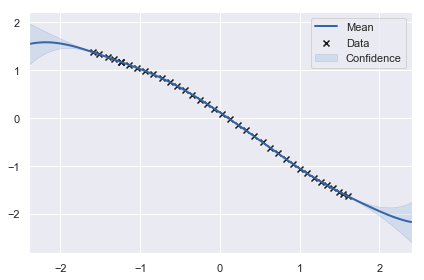

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


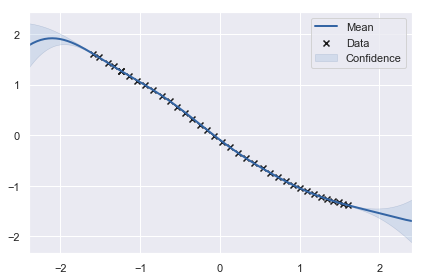

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


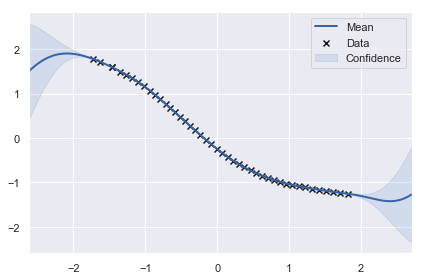

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


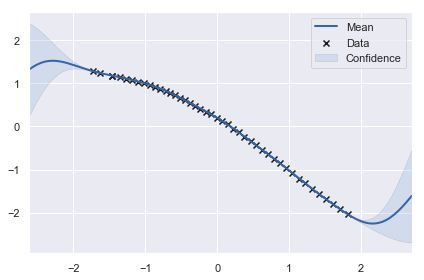

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


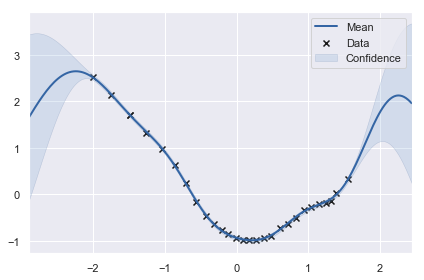

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


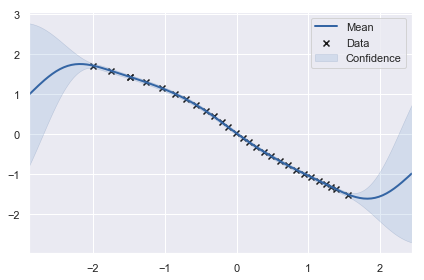

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


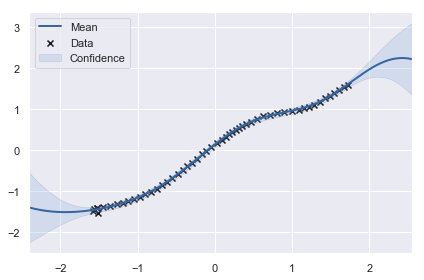

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


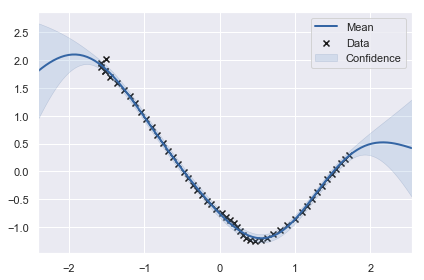

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


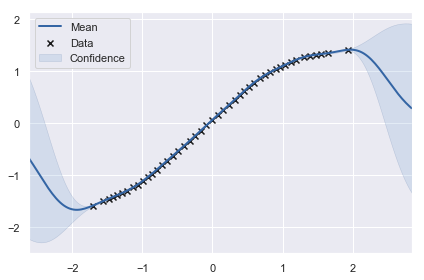

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


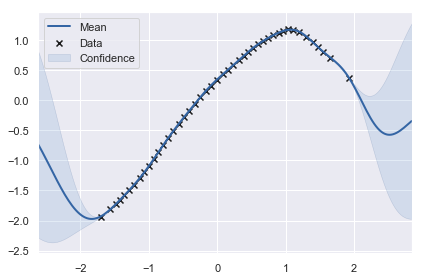

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


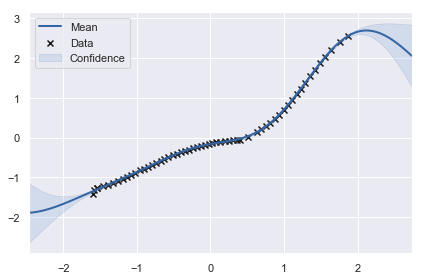

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


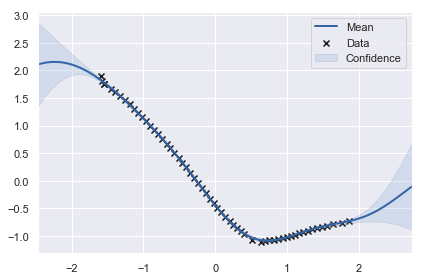

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


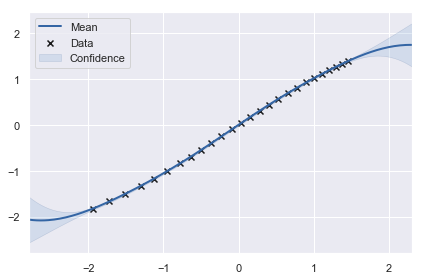

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


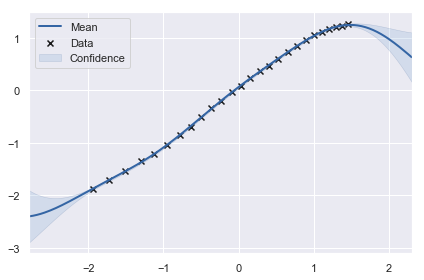

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


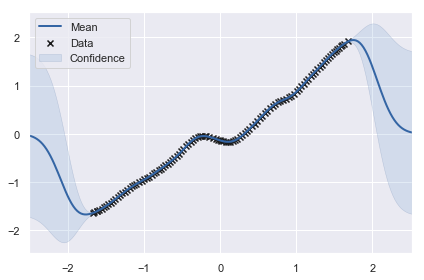

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


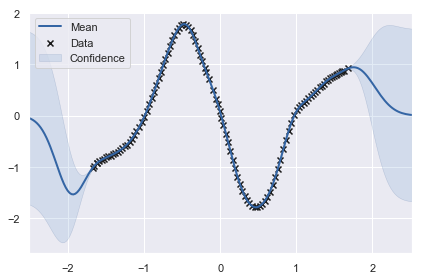

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


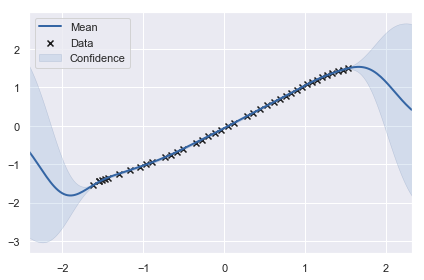

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


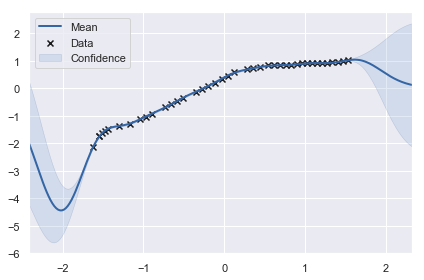

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


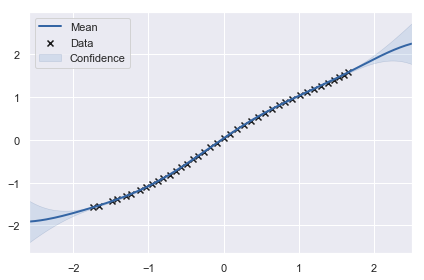

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


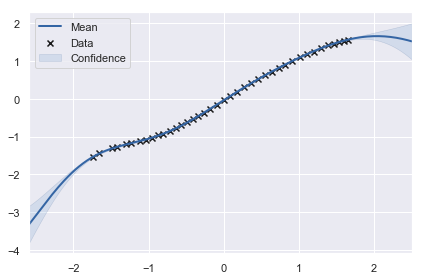

In [12]:
n_trajs = train.traj.unique()
traj_to_plot = n_trajs[1]
with gp.acquire_db_conn() as conn:
    for seg_n in n_segs:
        lik_model = gp.load(gp.LIKELIHOOD, route_n, traj_to_plot, seg_n, conn)
        lik_model.model.plot(which_data_ycols=[0])
        lik_model.model.plot(which_data_ycols=[1])
        #print(lik_model.model)
        #gp.plot(lik_model)
    

Let's do the same for the predictive GP

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


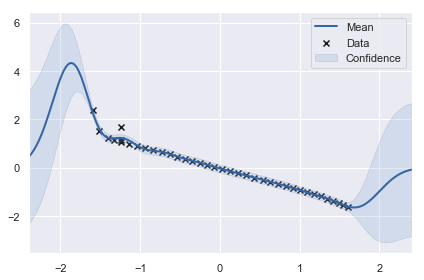

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


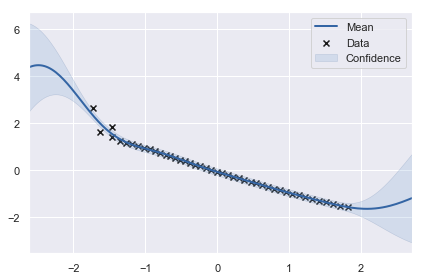

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


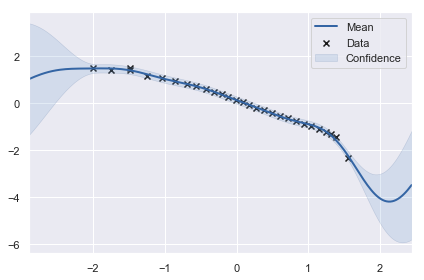

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


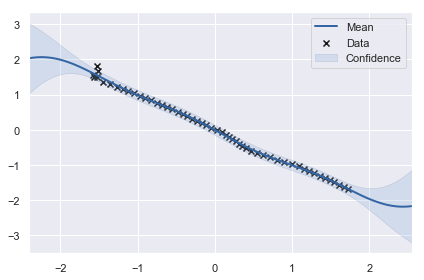

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


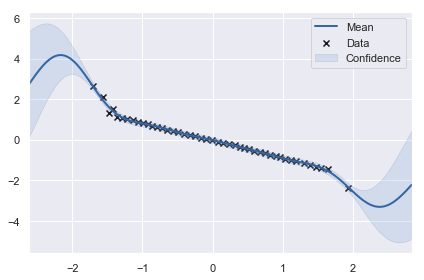

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


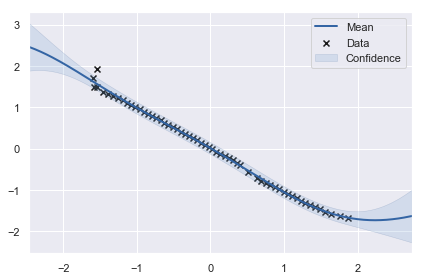

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


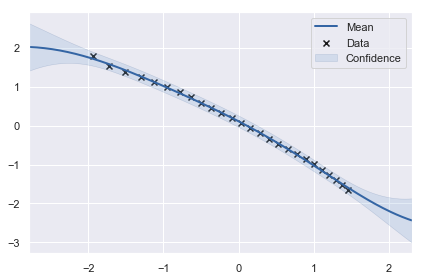

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


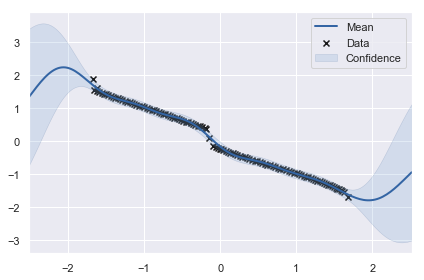

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


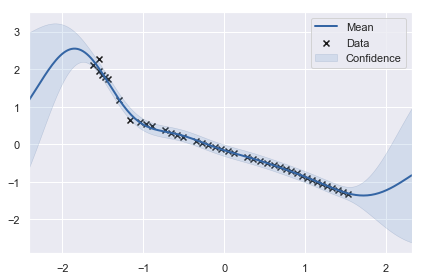

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


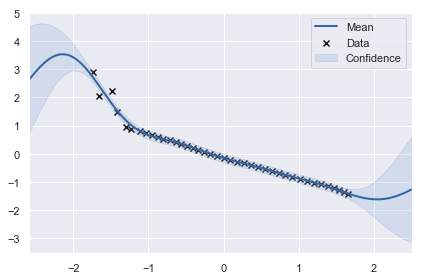

In [13]:
with gp.acquire_db_conn() as conn:
    for seg_n in n_segs:
        pred_model = gp.load(gp.PREDICTION, route_n, traj_to_plot, seg_n, conn)
        gp.plot(pred_model)
        #print(pred_model.model)
    

In [ ]:
import GPy
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    print(pred_model.route_n, pred_model.traj_n, pred_model.seg_n)
    pred_model.model.plot()

The results for both the GPs look decent. We'll save both to disk.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:22: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



true model 3 24 2
pred: 16.88 true: 23.0 MAE: 6.12 MAPE: 0.27


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


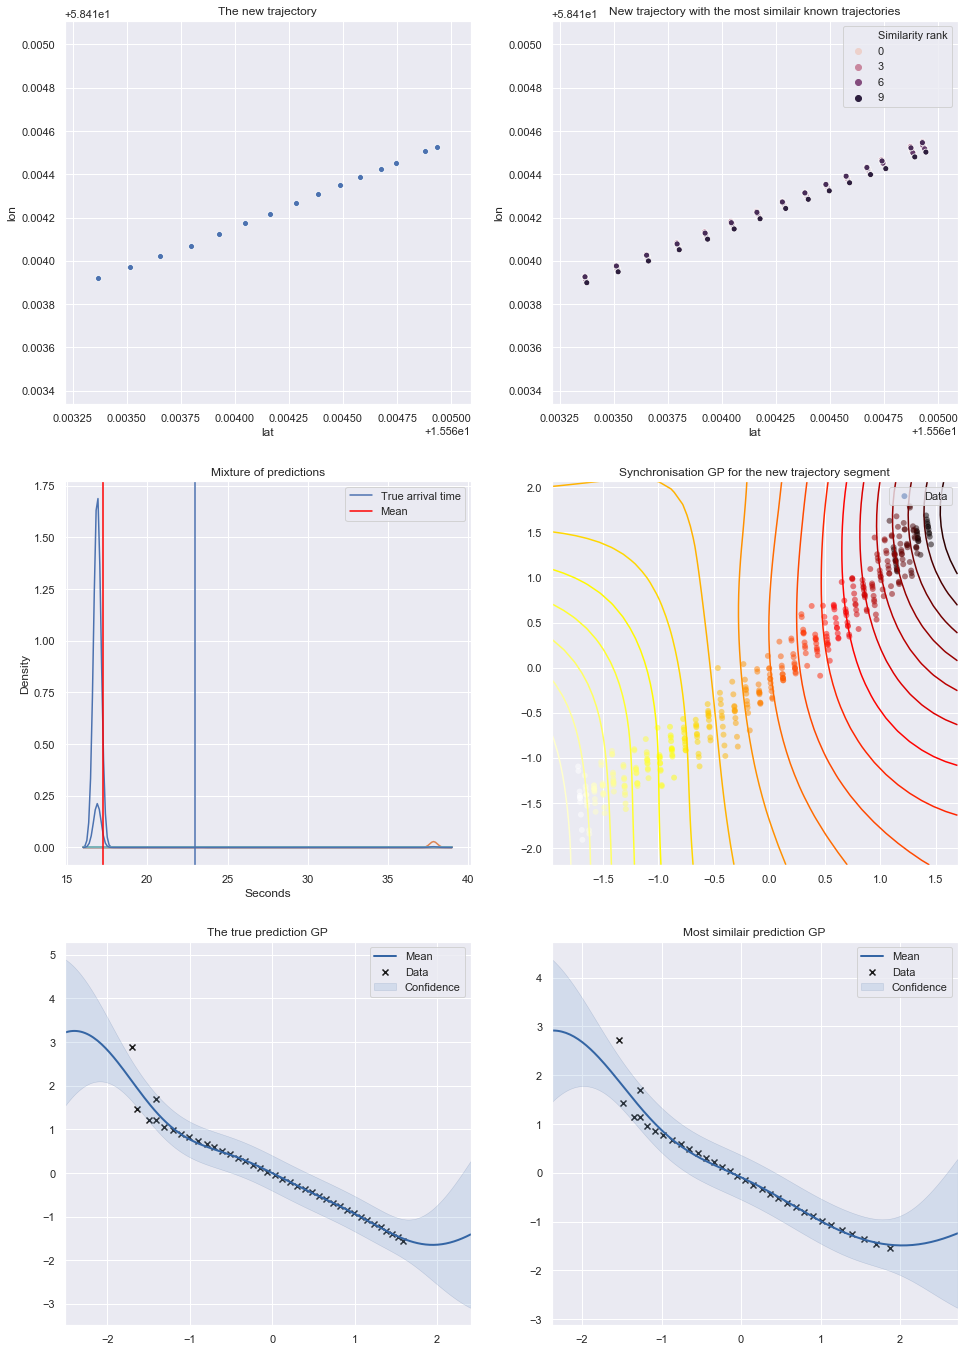

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from functools import reduce

def plot_likelihood_models(models_by_loglik, synched_traj):
    
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
 
    #print([(m[0].route_n, m[0].traj_n, m[0].seg_n) for m in models_by_loglik[:n_models_to_plot]])
    X = synched_traj[['tau']].values
    n_models_to_plot = 10
    models_to_plot = models_by_loglik[:n_models_to_plot]
    n_models = len(models_to_plot)
    dfs = [to_df(mloglik[0], i) for mloglik, i in zip(models_to_plot, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

    
def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, conn, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y):
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
        
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(gp.PREDICTION, lik_model.route_n, lik_model.traj_n, lik_model.seg_n, conn)
        
    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)
        max_loglik = models_by_loglik[0][1]
        
        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)
            
        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]
    
    synched_traj = synch_traj(synch_gp, traj)
    lik_models = gp.load_trajs(gp.LIKELIHOOD, route_n, seg_n, conn)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    #print('Most similair model', lik_models_with_weights[0][0].route_n, lik_models_with_weights[0][0].traj_n, lik_models_with_weights[0][0].seg_n)
    
    if plot:
        pred_models_with_weights[0][0].model.plot(ax=axs[2, 1])
        axs[2, 1].set_title('Most similair prediction GP')
        
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, conn, arrival_time=None, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, conn, plot)
    # Don't use all routes. The later ones have crazy small weights
    # leading to numerical issues.
    mean_var_weights = mean_var_weights[:10] 
    sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
    xmin = max(0, np.floor(float(sort[0][0]-sort[0][1]*3)))
    xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
    if plot:
        x = np.linspace(xmin, xmax, 200)
        for mean, var, w in mean_var_weights:
            axs[1,0].plot(x, w*norm.pdf(x, float(mean), np.sqrt(float(var))))
            
        axs[1,0].set_title('Mixture of predictions')
        axs[1,0].set_xlabel('Seconds')
        axs[1,0].set_ylabel('Density')
        if arrival_time:
            axs[1,0].axvline(x=arrival_time, label='True arrival time')
    
    #models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    #models_by_mode = sorted(mean_var_weights, key=lambda p: p[0]*p[2], reverse=True)
    n = 8
    delta = 1/n
    xx = np.linspace(xmin, xmax, (xmax-xmin)*n)
    total_weight = sum([w for _, _, w in mean_var_weights])
    norms = [w*norm.pdf(xx, float(mean), np.sqrt(float(var))) for mean, var, w in mean_var_weights]
    mixture = reduce(np.add, norms)
    mixture = mixture/sum(mixture)
    mean = xmin + delta*round(reduce(lambda tot, m: tot + m[0]*m[1], enumerate(mixture), 0))
    if plot:
        axs[1,0].plot(xx, mixture)
        axs[1,0].axvline(x=mean, label='Mean', color='red')
        axs[1,0].legend()
        
    mode = xmin + delta*np.argmax(mixture)
    #weighted_mean = sum([w*float(mean) for mean, var, w in mean_var_weights])
    
    #weighted_means = [w*float(mean) for mean, var, w in mean_var_weights]
    #print(weighted_means)
    #mode_model = models_by_mode[0] #mean_var_weights[np.argmax(weighted_means)]
    
    #print(mode_model)
    #n = 200
    #distribution = np.sum([norm.pdf(n, float(mean), np.sqrt(float(var))) for mean, var, w in mean_var_weights])
   
    #print(weighted_means)
    #print(mode_model)
    return mode #float(mode_model[0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = train #pd.read_pickle('test.pkl')
n_test_trajs_to_use = 38
n_test_trajs = test.traj.unique()
test = test[test.traj < n_test_trajs[n_test_trajs_to_use]]
traj_n = n_test_trajs[0]
test_traj = test[test.traj == traj_n]
seg_ix = 0
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, seg_n, conn, true_pred_gp=None):
    i = test_seg.index[0]+15 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n, conn)
    true = seg.iloc[-1].time_left
    pred = predict(seg, synch_gp, route_n, seg_n, conn, true, plot=True)
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print('true model', route_n, traj_n, seg_n)
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    if true_pred_gp:
        true_pred_gp.model.plot(ax=axs[2, 0])
        axs[2,0].set_title('The true prediction GP')
    
conn = gp.acquire_db_conn()
#print(test_seg[['lat', 'lon']])
pred_gp = gp.load(gp.PREDICTION, route_n, traj_n, seg_n, conn)
predict_seg_with_plots(test_seg, route_n, seg_n, conn, true_pred_gp=pred_gp)

In [40]:
from IPython.display import display, clear_output
from collections import defaultdict

seg_sizes = [.2, .4, .6, .8]
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
segs = dict(tuple(test.groupby('seg')))
with gp.acquire_db_conn() as conn:
    for seg_i, seg_n in enumerate(segs):
        seg = segs[seg_n]
        synch_gp = gp.load_synch(route_n, seg_n, conn)
        trajs = dict(tuple(seg.groupby('traj')))
        for traj_n in trajs:
            traj = trajs[traj_n]
            for size in seg_sizes:
                n = round(traj.shape[0]*size)
                traj_start = traj[:n]
                i = np.random.randint(traj.index[0], traj.index[-1])
                traj_start = traj[traj.index <= i]
                y = traj_start.iloc[-1].time_left
                pred = predict(traj_start, synch_gp, route_n, int(seg_n), conn, y, plot=False)
                mae[size][seg_n][traj_n]  = float(np.abs(y-pred))
                mape[size][seg_n][traj_n] = float(np.abs((y-pred)/y))
                #mae.append(float(np.abs(true-pred)))
                #mape.append(float(np.abs((true-pred)/true)))
        
        clear_output(wait=True)
        display('processed segment ' + str(seg_i+1) + ' out of ' + str(len(segs)))

print('Done!')

#print('MAPE: ', np.sum(mape)/len(mape))
#print('MAE: ', np.sum(mae)/len(mae))

'processed segment 9 out of 10'

Done!


In [44]:
for size in seg_sizes:
    final_mape = []
    final_mae = []
    for seg_n in segs:
        for traj_n in segs[seg_n].traj.unique():
            final_mape.append(mape[size][seg_n][traj_n])
            final_mae.append(mae[size][seg_n][traj_n])
    print('Size', size)
    print('MAPE', np.mean(final_mape))
    print('MAE', np.mean(final_mae))

Size 0.2
MAPE 0.24111707750771286
MAE 5.658552631578948
Size 0.4
MAPE 0.22553012758459942
MAE 5.805921052631579
Size 0.6
MAPE 0.2406502959009718
MAE 5.89375
Size 0.8
MAPE 0.2366064387496307
MAE 5.788815789473684


In [ ]:
for seg_n in n_segs[1:50]:
    seg = segs[seg_n]
    n_trajs = seg.traj.unique()
    trajs = dict(tuple(seg.groupby('traj')))
    for i, traj_n in enumerate(n_trajs):
        traj = trajs[traj_n]
        for size in seg_sizes:
            n = round(traj.shape[0]*size)
            traj_start = traj[:n]
            synch_gp = gp.load_synch(route_n, seg_n, version=version)
            X = traj_start[['lat', 'lon']]
            y = traj_start.iloc[-1].time_left
            pred = predict(X, synch_gp, route_n, int(seg_n), y, plot=False)
            mae[size][seg_n][traj_n]  = float(np.abs(y-pred))
            mape[size][seg_n][traj_n] = float(np.abs((y-pred)/y))
    
        clear_output(wait=True)
        display('Evaluated ' + str(i) + ' out of ' + str(len(n_trajs)) + ' trajs')
display('done')

In [ ]:
sgp = gp.load_synch(route_n, seg_n, version=2)
s_traj = synch_traj(sgp, test_seg)
m = gp.load(LIKELIHOOD_MODEL, 3, 139, seg_n)
df = pd.DataFrame(gp.predict(m, s_traj[['tau']].values)[0], columns=['lat' ,'lon'])
fig, ax = plt.subplots(1, 1)
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
ax.set_aspect('equal', 'datalim')
fig.set_figwidth(16)
fig.set_figheight(16)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(16)
most_likely_seg = train[(train.traj == 139) & (train.seg == seg_n)]
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=most_likely_seg, x='lat', y='lon', ax=ax, label='True most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
print(test_seg.shape[0])
print(most_likely_seg.shape[0])
for a, b in (zip(test_seg.time_left, most_likely_seg.time_left)):
    print(a, b)

Segments 1.0, 1.2, 1.4 are strange, does not seem to converge on one trajectory. Segment 4.2 has an 11 second jump at the final data point

In [ ]:
abs_errs = []

n_test_segs = test.seg.unique()
for traj_n in n_test_segs:
    traj = test[test.traj == traj_n]
    n_traj_segs = traj.seg.unique()
    for seg_n in n_traj_segs[0:1]:
        seg = traj[traj.seg == seg_n]
        i = np.random.randint(seg.index[0], seg.index[-1]-1)
        seg = seg[seg.index < i]
        synch_gp = gp.load_synch(route_n, seg_n, version=2)
        pred = predict(seg, synch_gp, route_n, seg_n)
        true = test_seg.iloc[-1].time_left
        abs_errs.append(np.abs((true-pred)/true))

mape = np.mean(abs_errs)
mape

In [ ]:
print(abs_errs)